# PREPROCESSING FACIAL EMOTION DATASET


## PREPROCESSING
Import all required library

In [1]:
import glob  # process file/folder path
import os # process file path
import pickle  # compress file

import numpy as np # process vector/matrix
import math
from scipy import ndimage  # multi-dimension image processing
import matplotlib.pyplot as plt # plot image

from skimage.util.montage import montage2d # plot image in batch
from skimage.color import rgb2gray

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

State all CONSTANT VARIABLES. Note that deciding the data set is big (get rid of Disgust) or small (keeps all but stay small as well due to the constraints of sharing number of samples between classes), is based on the value of variable IS_INCLUDED_DISGUST.

In [2]:
'''
LABEL OF DATASET
+ Angry:    4953   ->  4945
+ Disgust:  547    ->  547
+ Fear:     5121   ->  5121
+ Happy:    8989   ->  8988
+ Sad:      6077   ->  6076
+ Surprise: 4022   ->  4001
+ Neutral:  6198   ->  6197
'''

NUMB_EMOTIONS = 7
IMAGE_SIZE = 48
RGB = 3
IS_INCLUDED_DISGUST = False
SIZE_BALANCE_SMALL = 547
SIZE_BALANCE_BIG = 4001
TOTAL_SIZE = None
TRAIN_PERCENTAGE = 0.8
TEST_PERCENTAGE = 0.2
PIXEL_VALUE_RANGE = 255.

np.random.seed(0) # Keep the random pseudo generator to be deterministic

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
label_to_emotion = {i : emotions[i] for i in range(NUMB_EMOTIONS)}
emotion_to_label = {emotions[i] : i for i in range(NUMB_EMOTIONS)}

Define the plot image function, which might come in handy later on to observe any possible noise in original data set, as well as checking random distribution of the final one.

In [3]:
def plot_images(plotted_images, caption):
    
    plotted_images = (plotted_images - PIXEL_VALUE_RANGE / 2) / PIXEL_VALUE_RANGE
    plotted_images = [rgb2gray(i) for i in plotted_images]; 
        
    if (type(caption) == str):
        fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
        fig_montage = montage2d(np.array(plotted_images), rescale_intensity=True)
        ax1.imshow(fig_montage, cmap = 'gray', interpolation = 'none')
        ax1.set_title(caption)
        ax1.axis('off')
    else:
        fig = plt.figure()
        width_subplots = int(math.sqrt(len(plotted_images)))
        total_subplots = width_subplots * width_subplots
        fig.subplots_adjust(hspace=.5)
        for index in range(total_subplots):
            subfig = fig.add_subplot(width_subplots, width_subplots, index + 1)
            imgplot = plt.imshow(plotted_images[index], cmap='gray', 
                                 interpolation='None')
            subfig.set_title(caption[index])
            subfig.set_yticklabels([]), subfig.set_xticklabels([])
        plt.show()

Read data set from raw images, then save it in pickle format, but separately on class. 

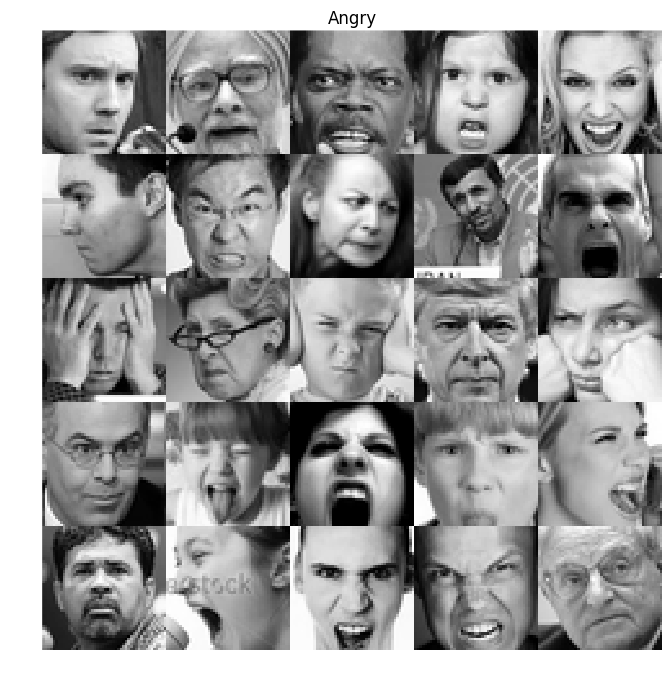

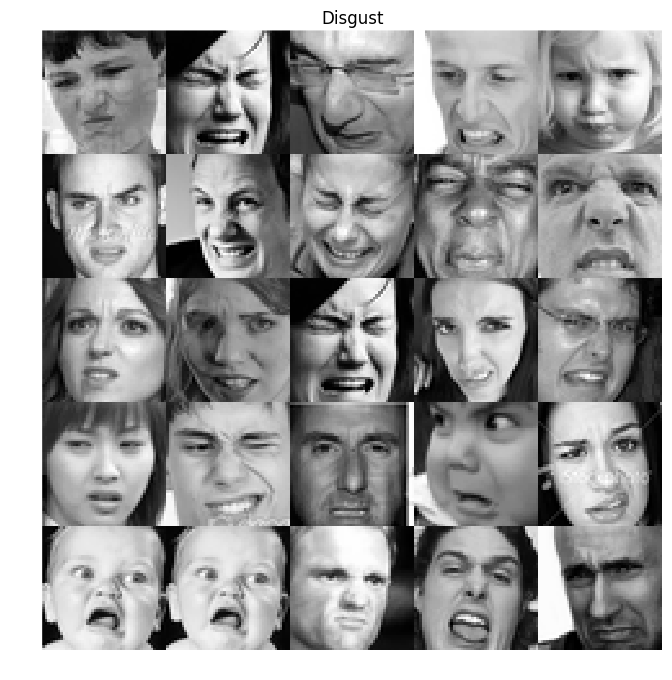

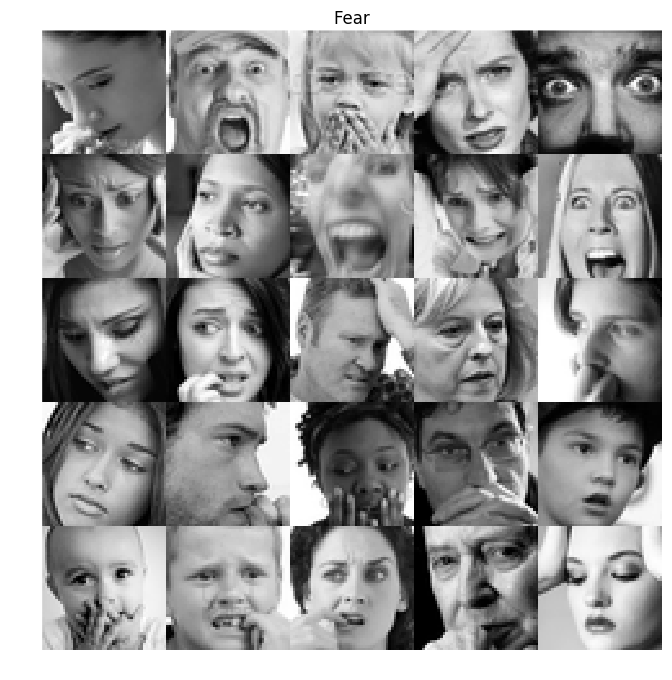

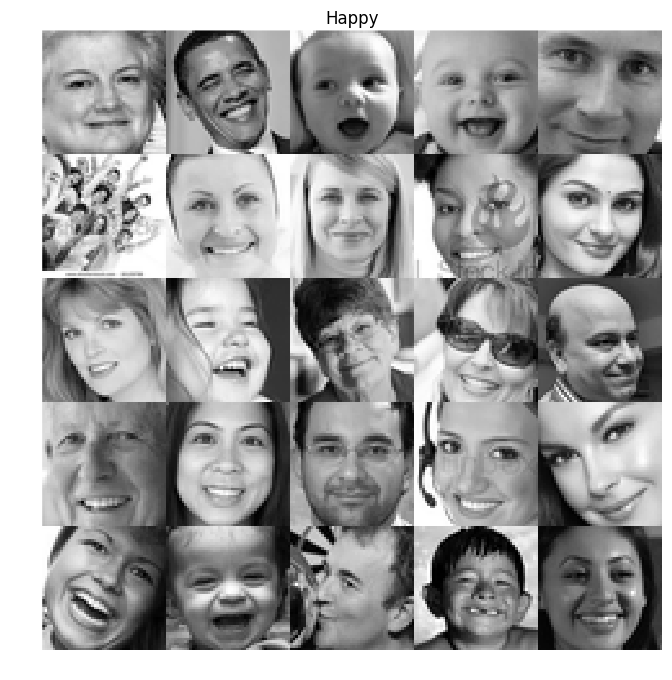

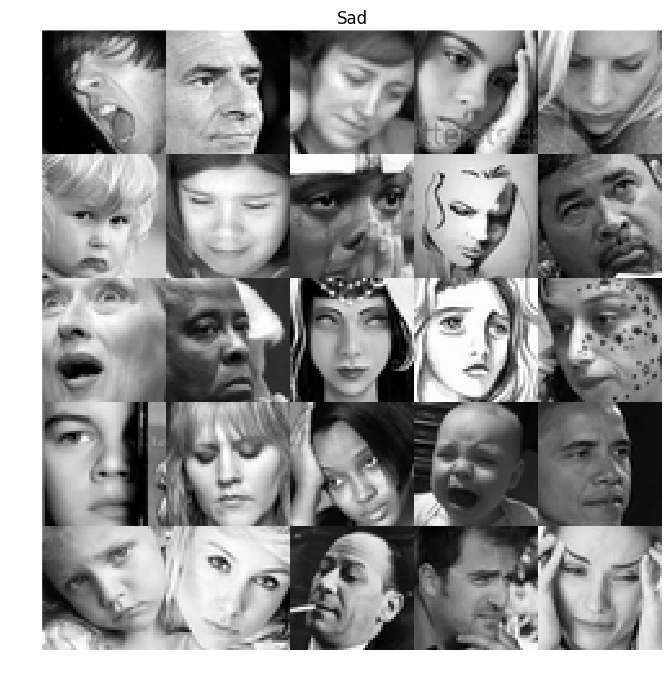

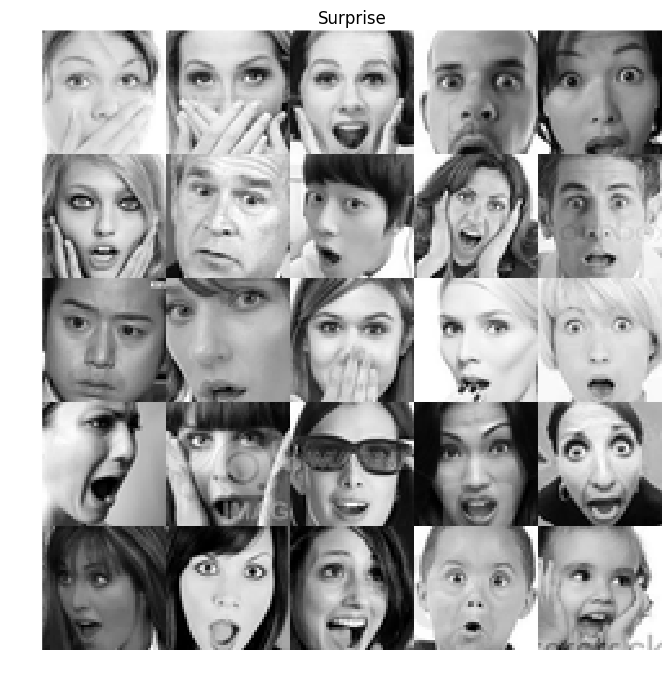

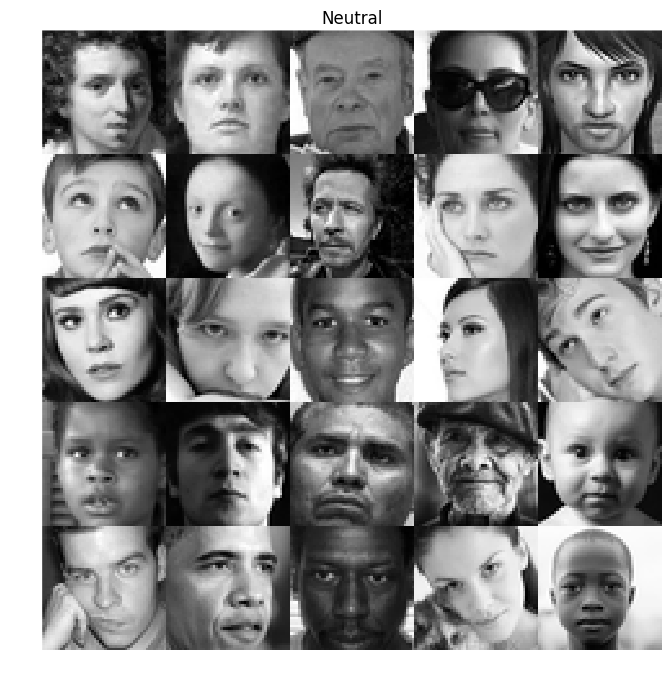

In [4]:
def load_emotion (folder):
    image_files = os.listdir(folder)
    numb_image_files = len(image_files)
    numb_processed_image = 0
    dataset = np.ndarray(shape = (numb_image_files, IMAGE_SIZE, IMAGE_SIZE, RGB),
                         dtype = np.float32)
    for image_file in glob.glob(folder + '/*.png'):
        try:
            image_data = ndimage.imread(image_file).astype(float)
            # Skip any image that all pixels sharing one value
            if (np.all(image_data == image_data[0])):
                continue
            dataset[numb_processed_image, :, :] = image_data
            numb_processed_image += 1
        except IOError as e:
            print ('Could not read: ' + image_file)
    # Rescale dataset to actually succesfully loaded image
    dataset = dataset[0:numb_processed_image, :, :, :]
    return dataset

def make_pickle (label_names):
    pickle_files = []
    for label in label_names:
        dataset = load_emotion(label)
        emotion_name = label_to_emotion[int(label)]
        plot_images(dataset[:25], emotion_name); 
        pickle_name = label + '.pickle'
        with open (pickle_name, 'wb') as f:
            pickle_files.append(pickle_name)
            pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    return pickle_files
            
label_names = [str(i) for i in range(NUMB_EMOTIONS)]
pickle_files = make_pickle(label_names)

Distribution each class equally into both training set and test set, guanranteering that no overlap exists.

In [5]:
def make_array(numb_rows, image_size):
    dataset = np.ndarray((numb_rows, IMAGE_SIZE, IMAGE_SIZE, RGB), dtype = np.float32)
    labels = np.ndarray(numb_rows, dtype = np.int32)
    return dataset, labels
    
def divide_dataset(pickle_files, train_size, test_size):
    train_dataset, train_labels = make_array(train_size, IMAGE_SIZE)
    test_dataset, test_labels = make_array(test_size, IMAGE_SIZE)
    train_size_per_class = train_size // NUMB_EMOTIONS
    test_size_per_class = test_size // NUMB_EMOTIONS
    
    start_train, start_test = 0, 0
    end_train, end_test = train_size_per_class, test_size_per_class
    end_size_per_class = train_size_per_class + test_size_per_class

    for label, pickle_file in enumerate(pickle_files):
        if (IS_INCLUDED_DISGUST == False):
            if (label == emotion_to_label['Disgust']):
                continue
        with open (pickle_file, 'rb') as f:
            emotion_set = pickle.load(f)
            # Shuffle all the faces having same emotion
            np.random.shuffle(emotion_set)
            train_set = emotion_set[:train_size_per_class, :, :, :]
            train_dataset[start_train:end_train, :, :, :] = train_set
            train_labels[start_train:end_train] = int(label)
            start_train += train_size_per_class
            end_train += train_size_per_class
            
            
            test_set = emotion_set[train_size_per_class:end_size_per_class, :, :, :]
            test_dataset[start_test:end_test, :, :, :] = test_set
            test_labels[start_test:end_test] = int(label)
            start_test += test_size_per_class
            end_test += test_size_per_class

    return train_dataset, train_labels, test_dataset, test_labels

pickle_files = [str(i) + '.pickle' for i in range(NUMB_EMOTIONS)]

if (IS_INCLUDED_DISGUST == True):
    TOTAL_SIZE = SIZE_BALANCE_SMALL * NUMB_EMOTIONS
else:
    NUMB_EMOTIONS = 6
    TOTAL_SIZE = SIZE_BALANCE_BIG * NUMB_EMOTIONS
train_size = int(TOTAL_SIZE * TRAIN_PERCENTAGE)
test_size = int(TOTAL_SIZE * TEST_PERCENTAGE)
    
train_dataset, train_labels, test_dataset, test_labels = divide_dataset(
                    pickle_files, train_size, test_size)


print('Training:', train_dataset.shape, train_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)    

Training: (19204, 48, 48, 3) (19204,)
Testing: (4801, 48, 48, 3) (4801,)


One final check of value of labels

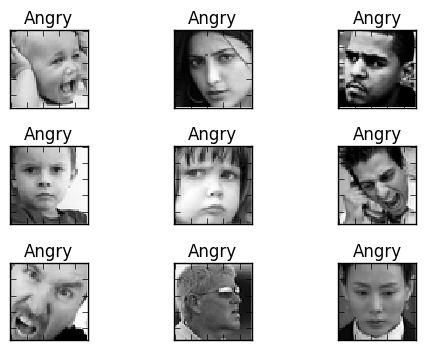

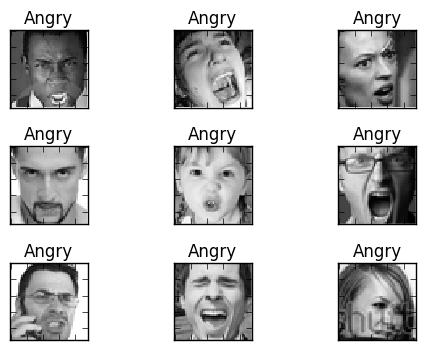

In [6]:
def filter_incorrect_label(dataset, labels):
    keep_indexes = []
    for index in range(len(labels)):
        label = labels[index]
        if (label in range(7)):
            keep_indexes.append(index)
    return dataset[keep_indexes], labels[keep_indexes]

train_dataset, train_labels = filter_incorrect_label(train_dataset, train_labels)
test_dataset, test_labels = filter_incorrect_label(test_dataset, test_labels)
plot_images(train_dataset[:10], [label_to_emotion[i] for i in train_labels[:10]])
plot_images(train_dataset[200:210], [label_to_emotion[i] for i in train_labels[200:210]])

Start to mix the class within training and test set by a simply random permutation

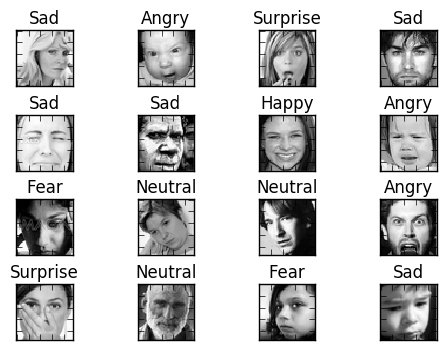

In [7]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
    
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

plot_images(train_dataset[:20], [label_to_emotion[i] for i in train_labels[:20]])


Now we can finally save the data as pickle format

In [8]:
pickle_file = None
if (IS_INCLUDED_DISGUST == True):
    pickle_file = 'faces_small.pickle'
else:
    pickle_file = 'faces_big.pickle'
    
with open (pickle_file, 'wb') as f:
    save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels, 
            'test_dataset': test_dataset,
            'test_labels': test_labels
            }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 663676054


## LOAD DATASET
The dataset would be saved and loaded as a dictionary with keys as follows: train_dataset, train_labels,test_dataset, test_labels

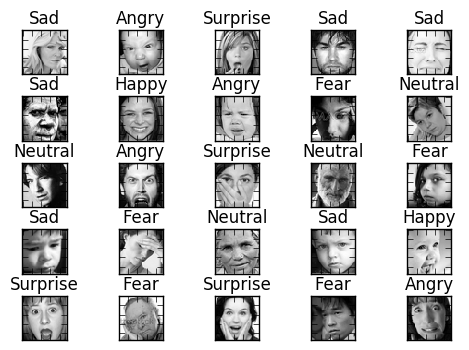

In [9]:
with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

keywords = dataset.keys()
train_dataset = dataset['train_dataset']
train_labels = dataset['train_labels']
test_dataset = dataset['test_dataset']
test_labels = dataset['test_labels']
plot_images(train_dataset[:30], [label_to_emotion[i] for i in train_labels[:30]])